<a href="https://colab.research.google.com/github/yasserius/satellite_image_tinhouse_detector/blob/main/inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

This is the inference notebook for drawing bounding boxes on satellite images.

From the top panel, just hit "Runtime > Run all"

Github repo: https://github.com/yasserius/satellite_image_tinhouse_detector

# Install the environment

Python 3.6 and Tensorflow 2.3 should work for this to work.

In [ ]:
!python --version

Python 3.6.9


In [ ]:
import tensorflow as tf
print(tf.__version__)

2.3.0


## Setting directory locations

In [ ]:
MODELS_DIR = "/content/models"
OBJ_DET_DIR = "/content/models/research/object_detection"

## Cloning from github

Following the [official guide](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2.md) to install.

In [ ]:
!git clone https://github.com/tensorflow/models.git

Cloning into 'models'...
remote: Enumerating objects: 48, done.
remote: Counting objects: 100% (48/48), done.
remote: Compressing objects: 100% (43/43), done.
remote: Total 46685 (delta 16), reused 37 (delta 5), pack-reused 46637
Receiving objects: 100% (46685/46685), 551.47 MiB | 37.56 MiB/s, done.
Resolving deltas: 100% (32045/32045), done.


In [ ]:
%%bash
cd models/research
# Compile protos.
protoc object_detection/protos/*.proto --python_out=.
# Install TensorFlow Object Detection API.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

Processing /content/models/research
  Created wheel for object-detection: filename=object_detection-0.1-cp36-none-any.whl size=1597036 sha256=074799e1688a47b0b737d7716ec412a7553d1896ae7f019720e0f2e38d5f1738
  Stored in directory: /tmp/pip-ephem-wheel-cache-oqfh4tj0/wheels/94/49/4b/39b051683087a22ef7e80ec52152a27249d1a644ccf4e442ea
  Created wheel for avro-python3: filename=avro_python3-1.10.0-cp36-none-any.whl size=43735 sha256=e2ce681a092aa6bfc591cab372c762329068da97e88f6b02437af74c39be6ffc
  Stored in directory: /root/.cache/pip/wheels/3f/15/cd/fe4ec8b88c130393464703ee8111e2cddebdc40e1b59ea85e9
  Created wheel for dill: filename=dill-0.3.1.1-cp36-none-any.whl size=78532 sha256=288e81addd8c0061cf78958aa59f74e5999dc43dc631d6103d70aa351fd6429e
  Stored in directory: /root/.cache/pip/wheels/59/b1/91/f02e76c732915c4015ab4010f3015469866c1eb9b14058d8e7
  Created wheel for future: filename=future-0.18.2-cp36-none-any.whl size=491057 sha256=286e9567a6a2a5315d07c81bc63e8b6ec15846cbff9dc852bc73

ERROR: multiprocess 0.70.10 has requirement dill>=0.3.2, but you'll have dill 0.3.1.1 which is incompatible.
ERROR: google-colab 1.0.0 has requirement requests~=2.23.0, but you'll have requests 2.24.0 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: apache-beam 2.25.0 has requirement avro-python3!=1.9.2,<1.10.0,>=1.8.1; python_version >= "3.0", but you'll have avro-python3 1.10.0 which is incompatible.


## Adding to path to environment variables

In [ ]:
import os

main_dir = "/content"
os.environ['PYTHONPATH'] += f':{main_dir}:{main_dir}/slim'
os.environ['PYTHONPATH'] += f':{main_dir}:{main_dir}/models'
os.environ['PYTHONPATH'] += f':{main_dir}:{main_dir}/models/research'

## Testing the installation

In [ ]:
!python "$OBJ_DET_DIR/builders/model_builder_tf2_test.py"

2020-10-30 12:39:34.735512: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
Running tests under Python 3.6.9: /usr/bin/python3
[ RUN      ] ModelBuilderTF2Test.test_create_center_net_model
2020-10-30 12:39:37.060123: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2020-10-30 12:39:37.114560: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-10-30 12:39:37.115141: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.73GiB deviceMemoryBandwidth: 298.08GiB/s
2020-10-30 12:39:37.115204: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully o

There will be a really long output.

But if the installation succeeded, you should see something like this at the bottom:

```
----------------------------------------------------------------------
Ran 20 tests in 45.495s

OK (skipped=1)
```

# Load the model

## Download model

The pretrained model (tensorflow checkpoint) is stored in this [Drive link](https://drive.google.com/uc?id=1QldfEaYxRvu2uxwhepAFmmFTgWn8_SCf&export=download).

In [ ]:
!pip install gdown

In [ ]:
import gdown
from zipfile import ZipFile

url = "https://drive.google.com/uc?id=1QldfEaYxRvu2uxwhepAFmmFTgWn8_SCf"
output_file = "model.zip"

gdown.download(url=url, output=output, quiet=True)

with ZipFile(output_file, 'r') as zipObj:
   zipObj.extractall()

## Load model

In [ ]:
import time
from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder

PATH_TO_CFG = "/content/export/pipeline.config"
PATH_TO_CKPT = "/content/export/checkpoint"

print('Loading model... ', end='')

# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(PATH_TO_CFG)
model_config = configs['model']
detection_model = model_builder.build(model_config=model_config, is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(PATH_TO_CKPT, 'ckpt-0')).expect_partial()

Loading model... 

## Download the label map file

In [ ]:
# Downlaod label map
!wget "https://raw.githubusercontent.com/yasserius/satellite_image_tinhouse_detector/main/label_map.pbtxt"

--2020-10-30 12:37:57--  https://raw.githubusercontent.com/yasserius/satellite_image_tinhouse_detector/main/label_map.pbtxt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 36 [text/plain]
Saving to: ‘label_map.pbtxt’

label_map.pbtxt     100%[===================>]      36  --.-KB/s    in 0s      

2020-10-30 12:37:57 (2.62 MB/s) - ‘label_map.pbtxt’ saved [36/36]



In [ ]:
category_index = label_map_util.create_category_index_from_labelmap("/content/label_map.pbtxt",
                                                                    use_display_name=True)

print(category_index)

{1: {'id': 1, 'name': 'house'}}


## Download test images

In [ ]:
%%bash
wget "https://raw.githubusercontent.com/yasserius/satellite_image_tinhouse_detector/main/images/test/1.png"
wget "https://raw.githubusercontent.com/yasserius/satellite_image_tinhouse_detector/main/images/test/2.png"
wget "https://raw.githubusercontent.com/yasserius/satellite_image_tinhouse_detector/main/images/test/3.png"

# Run inference

In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')   # Suppress Matplotlib warnings

def load_image_into_numpy_array(path):
    return np.array(Image.open(path))

If you want to test this on satellite images of your own, upload them to colab from the left panel and run the cells below.

Tip: make sure the images are square-ish and at least 500 by 500 in size.

In [ ]:
TEST_IMAGES = glob.glob("/content/*.png")

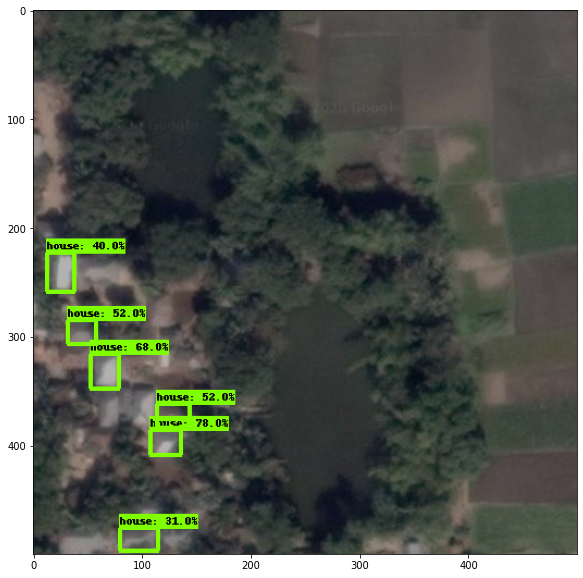

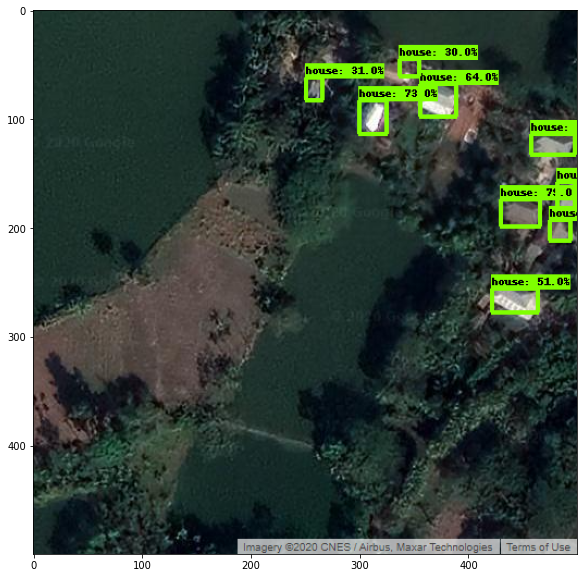

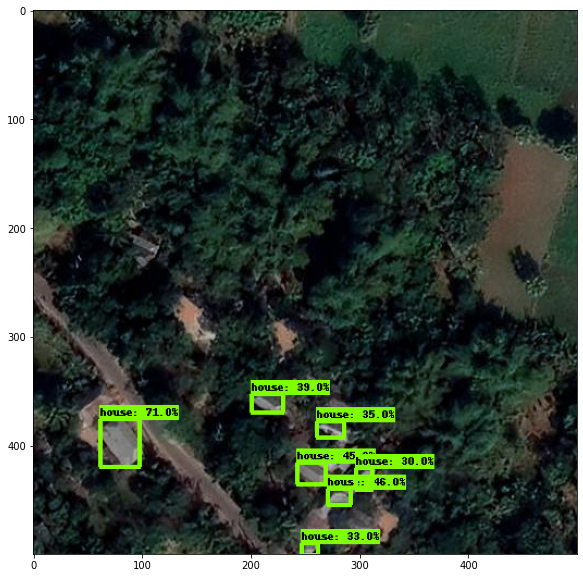

In [ ]:
import glob

for image_path in TEST_IMAGES:
  image_np = load_image_into_numpy_array(image_path)

  if image_np.shape[2] == 4:
    image_np = image_np[:, :, 0:3] # png has 4th channel

  input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)

  image, shapes = detection_model.preprocess(input_tensor)
  prediction_dict = detection_model.predict(image, shapes)
  detections = detection_model.postprocess(prediction_dict, shapes)

  num_detections = int(detections.pop('num_detections'))
  detections = {key: value[0, :num_detections].numpy()
                for key, value in detections.items()}
  detections['num_detections'] = num_detections

  detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

  label_id_offset = 1
  image_np_with_detections = image_np.copy()

  viz_utils.visualize_boxes_and_labels_on_image_array(
    image_np_with_detections,
    detections['detection_boxes'],
    detections['detection_classes']+label_id_offset,
    detections['detection_scores'],
    category_index,
    use_normalized_coordinates=True,
    max_boxes_to_draw=200,
    min_score_thresh=.30,
    agnostic_mode=False)
  
  plt.figure(figsize=(10,10))
  plt.imshow(image_np_with_detections)

plt.show()